**Libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/x.zip

Archive:  /content/drive/MyDrive/x.zip
   creating: x/
  inflating: x/ROIs1868_summer_s1_59_p10.png  
  inflating: x/ROIs1868_summer_s1_59_p100.png  
  inflating: x/ROIs1868_summer_s1_59_p101.png  
  inflating: x/ROIs1868_summer_s1_59_p102.png  
  inflating: x/ROIs1868_summer_s1_59_p103.png  
  inflating: x/ROIs1868_summer_s1_59_p104.png  
  inflating: x/ROIs1868_summer_s1_59_p105.png  
  inflating: x/ROIs1868_summer_s1_59_p106.png  
  inflating: x/ROIs1868_summer_s1_59_p107.png  
  inflating: x/ROIs1868_summer_s1_59_p11.png  
  inflating: x/ROIs1868_summer_s1_59_p113.png  
  inflating: x/ROIs1868_summer_s1_59_p114.png  
  inflating: x/ROIs1868_summer_s1_59_p115.png  
  inflating: x/ROIs1868_summer_s1_59_p116.png  
  inflating: x/ROIs1868_summer_s1_59_p117.png  
  inflating: x/ROIs1868_summer_s1_59_p118.png  
  inflating: x/ROIs1868_summer_s1_59_p119.png  
  inflating: x/ROIs1868_summer_s1_59_p12.png  
  inflating: x/ROIs1868_summer_s1_59_p120.png  
  inflating: x/ROIs1868_summer_s1_59

In [ ]:
!mv /content/x/* /content/drive/MyDrive/prototype/Train/x/
!mv /content/y/* /content/drive/MyDrive/prototype/Train/y/

In [ ]:
import os

print(len(os.listdir('/content/drive/MyDrive/prototype/Train/x')))
print(len(os.listdir('/content/drive/MyDrive/prototype/Train/y')))

1000


In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import models
from tqdm import tqdm


# Building Generator

In [ ]:
# Generator model (U-Net for SAR to RGB translation)
# Define the downsampling block
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, apply_batchnorm=True):
        super(DownSample, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)
        ]
        if apply_batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

# Define the upsampling block
class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels, apply_dropout=False):
        super(Upsample, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]
        if apply_dropout:
            layers.append(nn.Dropout(0.5))
        self.block = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.block(x)
        x = torch.cat((x, skip_input), 1)
        return x

# Generator adapted for SAR images
class Generator(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):  # 1 input channel (SAR), 3 output channels (RGB)
        super(Generator, self).__init__()
        self.down1 = DownSample(in_channels, 64)
        self.down2 = DownSample(64, 128)
        self.down3 = DownSample(128, 256)
        self.down4 = DownSample(256, 512)
        self.down5 = DownSample(512, 512)
        self.down6 = DownSample(512, 512)
        self.down7 = DownSample(512, 512)
        self.down8 = DownSample(512, 512)

        self.up1 = Upsample(512, 512)
        self.up2 = Upsample(1024, 512)
        self.up3 = Upsample(1024, 512)
        self.up4 = Upsample(1024, 512)
        self.up5 = Upsample(1024, 256)
        self.up6 = Upsample(512, 128)
        self.up7 = Upsample(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, kernel_size=4, padding=1),  # 3 output channels (RGB)
            nn.Tanh(),
        )

    def forward(self, x):
        # U-NET generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)
        u8 = self.final(u7)

        return u8


# **Building Discriminator**

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=4):
        super(Discriminator, self).__init__()
        def discriminator_block(in_filters, out_filters, stride=2, normalize=True):
            """Returns layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, kernel_size=4, stride=stride, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512, stride=1),
            nn.Conv2d(512, 1, kernel_size=4, padding=1)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

# **Defining Loss Functions**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# criterion_GAN = nn.MSELoss()
# criterion_pixelwise = nn.L1Loss()

"""# Chromatic Aberration Loss definition
class ChromaticAberrationLoss(nn.Module):
    def __init__(self, lambda_color=1.0, lambda_spatial=1.0, lambda_perceptual=1.0, lambda_edge=1.0):
        super(ChromaticAberrationLoss, self).__init__()
        self.lambda_color = lambda_color
        self.lambda_spatial = lambda_spatial
        self.lambda_perceptual = lambda_perceptual
        self.lambda_edge = lambda_edge

        # Pre-trained VGG19 model for perceptual loss
        vgg19 = models.vgg19(pretrained=True).features
        self.vgg19_block4_conv4 = nn.Sequential(*list(vgg19[:21])).eval()  # Block 4 conv 4
        for param in self.vgg19_block4_conv4.parameters():
            param.requires_grad = False

    # Convert from RGB to YUV (PyTorch version)
    def rgb_to_yuv(self, image):
        r, g, b = image[:, 0:1], image[:, 1:1], image[:, 2:1]
        y = 0.299 * r + 0.587 * g + 0.114 * b
        u = -0.14713 * r - 0.28886 * g + 0.436 * b
        v = 0.615 * r - 0.51499 * g - 0.10001 * b
        return torch.cat([y, u, v], dim=1)

    # 1. Color Discrepancy Loss (L2 Norm in YUV space)
    def color_loss(self, y_true, y_pred):
        y_true_yuv = self.rgb_to_yuv(y_true)
        y_pred_yuv = self.rgb_to_yuv(y_pred)
        return torch.mean((y_true_yuv - y_pred_yuv) ** 2)

    # 2. Spatial Consistency Loss (L1 Norm between neighboring pixels)
    def spatial_loss(self, image):
        loss_vertical = torch.mean(torch.abs(image[:, :, :-1, :] - image[:, :, 1:, :]))
        loss_horizontal = torch.mean(torch.abs(image[:, :, :, :-1] - image[:, :, :, 1:]))
        return loss_vertical + loss_horizontal

    # 3. Perceptual Loss (using VGG19)
    def perceptual_loss(self, y_true, y_pred):
        y_true_vgg = self.vgg19_block4_conv4(y_true)
        y_pred_vgg = self.vgg19_block4_conv4(y_pred)
        return torch.mean((y_true_vgg - y_pred_vgg) ** 2)

    # 4. Edge-Aware Loss (gradient difference in edge areas)
    def edge_aware_loss(self, y_true, y_pred):
        grad_true_x = y_true[:, :, 1:, :] - y_true[:, :, :-1, :]
        grad_true_y = y_true[:, :, :, 1:] - y_true[:, :, :, :-1]
        grad_pred_x = y_pred[:, :, 1:, :] - y_pred[:, :, :-1, :]
        grad_pred_y = y_pred[:, :, :, 1:] - y_pred[:, :, :, :-1]

        edge_loss = torch.mean(torch.abs(grad_true_x - grad_pred_x)) + \
                    torch.mean(torch.abs(grad_true_y - grad_pred_y))
        return edge_loss

    # Total Chromatic Aberration Loss
    def forward(self, y_true, y_pred):
        color_loss_value = self.color_loss(y_true, y_pred)
        spatial_loss_value = self.spatial_loss(y_pred)
        perceptual_loss_value = self.perceptual_loss(y_true, y_pred)
        edge_loss_value = self.edge_aware_loss(y_true, y_pred)

        total_loss = (self.lambda_color * color_loss_value) + \
                     (self.lambda_spatial * spatial_loss_value) + \
                     (self.lambda_perceptual * perceptual_loss_value) + \
                     (self.lambda_edge * edge_loss_value)

        return total_loss"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# Convert RGB to LAB using PyTorch
def rgb_to_lab(image):
    # The conversion logic from RGB to LAB will be approximated.
    # For simplicity, here we assume the image is normalized to [0, 1].
    image = (image + 1) / 2  # Denormalize from [-1, 1] to [0, 1]
    image = image.clamp(0, 1)  # Ensure pixel values are within [0, 1]

    # You can use a library like OpenCV to convert to LAB, but here's a placeholder
    # You would need to use `cv2.cvtColor(image, cv2.COLOR_RGB2LAB)` with actual data.
    # Placeholder conversion: Assume yuv is LAB (for simplicity)
    return image  # This would be replaced by actual LAB conversion logic

# # Chromatic Aberration Loss in PyTorch
# class ChromaticAberrationLoss(nn.Module):
#     def __init__(self, lambda_color=1.0, lambda_spatial=1.0, lambda_perceptual=1.0, lambda_edge=1.0):
#         super(ChromaticAberrationLoss, self).__init__()
#         self.lambda_color = lambda_color
#         self.lambda_spatial = lambda_spatial
#         self.lambda_perceptual = lambda_perceptual
#         self.lambda_edge = lambda_edge

#         # Load the pre-trained VGG19 model for perceptual loss
#         vgg = models.vgg19(pretrained=True).features
#         self.vgg = nn.Sequential(*list(vgg.children())[:22])  # Extract up to 'block4_conv4'
#         for param in self.vgg.parameters():
#             param.requires_grad = False  # Freeze VGG19 parameters

#     def forward(self, y_true, y_pred):
#         # 1. Color Discrepancy Loss (L2 Norm in LAB space)
#         y_true_lab = rgb_to_lab(y_true)
#         y_pred_lab = rgb_to_lab(y_pred)
#         color_loss = F.mse_loss(y_true_lab, y_pred_lab)

#         # 2. Spatial Consistency Loss (L1 Norm between neighboring pixels)
#         def spatial_loss(image):
#             loss_x = F.l1_loss(image[:, :, :-1, :], image[:, :, 1:, :])
#             loss_y = F.l1_loss(image[:, :, :, :-1], image[:, :, :, 1:])
#             return loss_x + loss_y

#         spatial_loss_value = spatial_loss(y_pred)

#         # 3. Perceptual Loss using VGG19 features
#         def perceptual_loss(y_true, y_pred):
#             y_true_vgg = self.vgg(y_true)
#             y_pred_vgg = self.vgg(y_pred)
#             return F.mse_loss(y_true_vgg, y_pred_vgg)

#         perceptual_loss_value = perceptual_loss(y_true, y_pred)

#         # 4. Edge-Aware Loss (gradient difference in edge areas)
#         def edge_aware_loss(y_true, y_pred):
#             grad_true_x = y_true[:, :, 1:, :] - y_true[:, :, :-1, :]
#             grad_true_y = y_true[:, :, :, 1:] - y_true[:, :, :, :-1]
#             grad_pred_x = y_pred[:, :, 1:, :] - y_pred[:, :, :-1, :]
#             grad_pred_y = y_pred[:, :, :, 1:] - y_pred[:, :, :, :-1]
#             edge_loss = F.l1_loss(grad_true_x, grad_pred_x) + F.l1_loss(grad_true_y, grad_pred_y)
#             return edge_loss

#         edge_loss_value = edge_aware_loss(y_true, y_pred)

#         # Total Chromatic Aberration Loss
#         total_loss = (self.lambda_color * color_loss) + \
#                      (self.lambda_spatial * spatial_loss_value) + \
#                      (self.lambda_perceptual * perceptual_loss_value) + \
#                      (self.lambda_edge * edge_loss_value)

#         return total_loss

class ChromaticAberrationLoss(nn.Module):
    def __init__(self, device, lambda_color=1.0, lambda_spatial=1.0, lambda_perceptual=1.0, lambda_edge=1.0):
        super(ChromaticAberrationLoss, self).__init__()
        self.lambda_color = lambda_color
        self.lambda_spatial = lambda_spatial
        self.lambda_perceptual = lambda_perceptual
        self.lambda_edge = lambda_edge

        # Load the pre-trained VGG19 model for perceptual loss and move it to the appropriate device
        vgg = models.vgg19(pretrained=True).features
        self.vgg = nn.Sequential(*list(vgg.children())[:22])  # Extract up to 'block4_conv4'
        self.vgg.to(device)  # Move the VGG model to the appropriate device (GPU/CPU)

        for param in self.vgg.parameters():
            param.requires_grad = False  # Freeze VGG19 parameters

        self.device = device  # Store device for later use

    def forward(self, y_true, y_pred):
        # Move inputs to the same device as the model (VGG)
        y_true = y_true.to(self.device)
        y_pred = y_pred.to(self.device)

        # 1. Color Discrepancy Loss (L2 Norm in LAB space)
        y_true_lab = rgb_to_lab(y_true)
        y_pred_lab = rgb_to_lab(y_pred)
        color_loss = F.mse_loss(y_true_lab, y_pred_lab)

        # 2. Spatial Consistency Loss (L1 Norm between neighboring pixels)
        def spatial_loss(image):
            loss_x = F.l1_loss(image[:, :, :-1, :], image[:, :, 1:, :])
            loss_y = F.l1_loss(image[:, :, :, :-1], image[:, :, :, 1:])
            return loss_x + loss_y

        spatial_loss_value = spatial_loss(y_pred)

        # 3. Perceptual Loss using VGG19 features
        def perceptual_loss(y_true, y_pred):
            y_true_vgg = self.vgg(y_true)
            y_pred_vgg = self.vgg(y_pred)
            return F.mse_loss(y_true_vgg, y_pred_vgg)

        perceptual_loss_value = perceptual_loss(y_true, y_pred)

        # 4. Edge-Aware Loss (gradient difference in edge areas)
        def edge_aware_loss(y_true, y_pred):
            grad_true_x = y_true[:, :, 1:, :] - y_true[:, :, :-1, :]
            grad_true_y = y_true[:, :, :, 1:] - y_true[:, :, :, :-1]
            grad_pred_x = y_pred[:, :, 1:, :] - y_pred[:, :, :-1, :]
            grad_pred_y = y_pred[:, :, :, 1:] - y_pred[:, :, :, :-1]
            edge_loss = F.l1_loss(grad_true_x, grad_pred_x) + F.l1_loss(grad_true_y, grad_pred_y)
            return edge_loss

        edge_loss_value = edge_aware_loss(y_true, y_pred)

        # Total Chromatic Aberration Loss
        total_loss = (self.lambda_color * color_loss) + \
                     (self.lambda_spatial * spatial_loss_value) + \
                     (self.lambda_perceptual * perceptual_loss_value) + \
                     (self.lambda_edge * edge_loss_value)

        return total_loss

# Replace L1 loss with Chromatic Aberration Loss
criterion_GAN = nn.MSELoss()
criterion_pixelwise = ChromaticAberrationLoss(device, lambda_color=1.0, lambda_spatial=1.0, lambda_perceptual=1.0, lambda_edge=1.0)

# Example usage in your training loop
# Assuming the rest of your training setup is the same
# loss_pixel = criterion_pixelwise(generated_imgs, target_imgs)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 94.1MB/s]


# Optimizers and Transforms

In [ ]:
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.002, betas=(0.5, 0.999))

# Transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Dataset class for handling SAR input and DATALOADER

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import torchvision.transforms as transforms

# Define the dataset class
class ImageDataset(Dataset):
    def __init__(self, SAR_root, color_root=None, transforms_=None):
        self.SAR_root = SAR_root
        self.color_root = color_root
        self.transforms = transforms_

        # Get sorted list of SAR images
        self.SAR_images = sorted([f for f in os.listdir(SAR_root) if f.endswith('.png')])

        # If color images are provided, get sorted list of color images
        if color_root:
            self.color_images = sorted([f for f in os.listdir(color_root) if f.endswith('.png')])
            # Ensure the number of SAR and color images are the same
            assert len(self.SAR_images) == len(self.color_images), "Mismatch between SAR and color image count"

    def __len__(self):
        return len(self.SAR_images)

    def __getitem__(self, idx):
        # Load SAR image
        SAR_image_path = os.path.join(self.SAR_root, self.SAR_images[idx])
        SAR_image = Image.open(SAR_image_path).convert('L')  # Grayscale (1 channel)

        if self.color_root:
            # Load corresponding color image
            color_image_path = os.path.join(self.color_root, self.color_images[idx])
            color_image = Image.open(color_image_path).convert('RGB')  # RGB (3 channels)

            # Apply transformations if available
            if self.transforms:
                SAR_image = self.transforms(SAR_image)
                color_image = self.transforms(color_image)

            return SAR_image, color_image
        else:
            # Apply transformations to SAR image only
            if self.transforms:
                SAR_image = self.transforms(SAR_image)
            return SAR_image

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to match your model input size
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize (use 3 channels normalization if needed for color)
])

# DataLoader for training
dataloader = DataLoader(
    ImageDataset(
        SAR_root="/content/drive/MyDrive/prototype/Train/x",  # Path to SAR images
        color_root="/content/drive/MyDrive/prototype/Train/y",  # Path to color images
        transforms_=transform
    ),
    batch_size=16,  # Adjust the batch size as needed
    shuffle=True
)


In [ ]:


generator = generator.to(device)
discriminator = discriminator.to(device)

# Training

In [ ]:

# Paths to save the best models
save_path_generator = '/content/drive/MyDrive/prototype/Models/generator/generator.pth'
save_path_discriminator = '/content/drive/MyDrive/prototype/Models/discriminator/discriminator.pth'

# Early stopping parameters
patience = 5
best_loss_G = float('inf')
best_loss_D = float('inf')
no_improvement_G = 0
no_improvement_D = 0

# Get the total number of batches
total_batches = len(dataloader)

# Start the training loop
for epoch in range(200):
    start_time = time.time()  # Record start time for ETA calculation
    epoch_loss_G = 0
    epoch_loss_D = 0

    dataloader_tqdm = tqdm(dataloader, desc=f'Epoch {epoch+1}/200', leave=False)

    for i, (SAR_imgs, color_imgs) in enumerate(dataloader_tqdm):
        SAR_imgs = SAR_imgs.to(device)
        color_imgs = color_imgs.to(device)

        valid = torch.ones((SAR_imgs.size(0), 1, 30, 30), requires_grad=False).to(device)  # Adjust to match image size
        fake = torch.zeros((SAR_imgs.size(0), 1, 30, 30), requires_grad=False).to(device)  # Adjust to match image size

        # ------------------
        # Train Generator
        # ------------------
        optimizer_G.zero_grad()

        fake_imgs = generator(SAR_imgs)
        # Resize fake images to match color images size if necessary
        fake_imgs_resized = F.interpolate(fake_imgs, size=color_imgs.size()[2:], mode='bilinear', align_corners=False)

        # Ensure that fake_imgs_resized and color_imgs have the same size
        assert fake_imgs_resized.size() == color_imgs.size(), f"Size mismatch: {fake_imgs_resized.size()} vs {color_imgs.size()}"

        # GAN loss (Discriminator should classify fake images as valid)
        loss_GAN = criterion_GAN(discriminator(fake_imgs_resized, SAR_imgs), valid)

        # Pixel-wise loss
        loss_pixelwise = criterion_pixelwise(fake_imgs_resized, color_imgs)

        # Total generator loss
        loss_G = loss_GAN + loss_pixelwise
        loss_G.backward()

        # Gradient clipping
        nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
        optimizer_G.step()

        # ------------------
        # Train Discriminator
        # ------------------
        optimizer_D.zero_grad()

        # Real images (Discriminator should classify real images as valid)
        loss_real = criterion_GAN(discriminator(color_imgs, SAR_imgs), valid)

        # Fake images (Discriminator should classify generated images as fake)
        loss_fake = criterion_GAN(discriminator(fake_imgs_resized.detach(), SAR_imgs), fake)

        # Total discriminator loss
        loss_D = 0.5 * (loss_real + loss_fake)
        loss_D.backward()

        # Gradient clipping
        nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
        optimizer_D.step()

        epoch_loss_G += loss_G.item()
        epoch_loss_D += loss_D.item()

        # Calculate elapsed time and ETA
        elapsed_time = time.time() - start_time
        avg_time_per_batch = elapsed_time / (i + 1)
        remaining_batches = total_batches - (i + 1)
        eta = avg_time_per_batch * remaining_batches

        # Update the tqdm description with ETA
        dataloader_tqdm.set_postfix({
            'D loss': f'{loss_D.item():.4f}',
            'G loss': f'{loss_G.item():.4f}',
            'ETA': f'{eta:.2f}s'
        })

    # Calculate average loss for the epoch
    avg_loss_G = epoch_loss_G / len(dataloader)
    avg_loss_D = epoch_loss_D / len(dataloader)

    print(f"\n[Epoch {epoch+1}/200] [Avg D loss: {avg_loss_D:.4f}] [Avg G loss: {avg_loss_G:.4f}]")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds | ETA: {eta:.2f} seconds")

    # Early stopping and model checkpointing
    if avg_loss_G < best_loss_G:
        best_loss_G = avg_loss_G
        no_improvement_G = 0
        best_generator_state = generator.state_dict()
    else:
        no_improvement_G += 1

    if avg_loss_D < best_loss_D:
        best_loss_D = avg_loss_D
        no_improvement_D = 0
        best_discriminator_state = discriminator.state_dict()
    else:
        no_improvement_D += 1

    # Check for early stopping
    if no_improvement_G >= patience and no_improvement_D >= patience:
        print("Early stopping triggered. Training stopped.")
        break

# Save the final best models with architecture and optimizer state
torch.save({
    'model_state_dict': best_generator_state,
    'optimizer_state_dict': optimizer_G.state_dict(),
    'loss': best_loss_G,
}, save_path_generator)

torch.save({
    'model_state_dict': best_discriminator_state,
    'optimizer_state_dict': optimizer_D.state_dict(),
    'loss': best_loss_D,
}, save_path_discriminator)

print("Training complete. Best models saved.")



[Epoch 1/200] [Avg D loss: 3.6290] [Avg G loss: 39.2492]
Elapsed Time: 88.56 seconds | ETA: 0.00 seconds



[Epoch 2/200] [Avg D loss: 0.8902] [Avg G loss: 32.6170]
Elapsed Time: 82.78 seconds | ETA: 0.00 seconds



[Epoch 3/200] [Avg D loss: 0.4427] [Avg G loss: 31.7067]
Elapsed Time: 82.24 seconds | ETA: 0.00 seconds



[Epoch 4/200] [Avg D loss: 0.3859] [Avg G loss: 30.9559]
Elapsed Time: 82.00 seconds | ETA: 0.00 seconds



[Epoch 5/200] [Avg D loss: 0.1789] [Avg G loss: 30.5028]
Elapsed Time: 82.32 seconds | ETA: 0.00 seconds



[Epoch 6/200] [Avg D loss: 0.2176] [Avg G loss: 29.9215]
Elapsed Time: 82.22 seconds | ETA: 0.00 seconds



[Epoch 7/200] [Avg D loss: 0.1684] [Avg G loss: 29.0996]
Elapsed Time: 82.25 seconds | ETA: 0.00 seconds



[Epoch 8/200] [Avg D loss: 0.1558] [Avg G loss: 28.9755]
Elapsed Time: 82.41 seconds | ETA: 0.00 seconds



[Epoch 9/200] [Avg D loss: 0.2039] [Avg G loss: 28.5496]
Elapsed Time: 82.31 seconds | ETA: 0.00 seconds



[Epoch 10/200] [Avg D loss: 0.1797] [Avg G loss: 27.9860]
Elapsed Time: 82.05 seconds | ETA: 0.00 seconds



[Epoch 11/200] [Avg D loss: 0.1417] [Avg G loss: 27.6261]
Elapsed Time: 82.14 seconds | ETA: 0.00 seconds



[Epoch 12/200] [Avg D loss: 0.1212] [Avg G loss: 26.9520]
Elapsed Time: 82.03 seconds | ETA: 0.00 seconds



[Epoch 13/200] [Avg D loss: 0.1247] [Avg G loss: 26.5494]
Elapsed Time: 82.12 seconds | ETA: 0.00 seconds



[Epoch 14/200] [Avg D loss: 0.1085] [Avg G loss: 26.1171]
Elapsed Time: 82.30 seconds | ETA: 0.00 seconds



[Epoch 15/200] [Avg D loss: 0.0817] [Avg G loss: 25.6313]
Elapsed Time: 82.34 seconds | ETA: 0.00 seconds



[Epoch 16/200] [Avg D loss: 0.1010] [Avg G loss: 25.2538]
Elapsed Time: 82.45 seconds | ETA: 0.00 seconds



[Epoch 17/200] [Avg D loss: 0.0499] [Avg G loss: 24.6514]
Elapsed Time: 82.60 seconds | ETA: 0.00 seconds



[Epoch 18/200] [Avg D loss: 0.0543] [Avg G loss: 23.6404]
Elapsed Time: 82.45 seconds | ETA: 0.00 seconds



[Epoch 19/200] [Avg D loss: 0.0274] [Avg G loss: 23.2906]
Elapsed Time: 82.32 seconds | ETA: 0.00 seconds



[Epoch 20/200] [Avg D loss: 0.0189] [Avg G loss: 22.1750]
Elapsed Time: 82.43 seconds | ETA: 0.00 seconds



[Epoch 21/200] [Avg D loss: 0.0100] [Avg G loss: 21.3293]
Elapsed Time: 82.04 seconds | ETA: 0.00 seconds



[Epoch 22/200] [Avg D loss: 0.0155] [Avg G loss: 20.5000]
Elapsed Time: 82.11 seconds | ETA: 0.00 seconds



[Epoch 23/200] [Avg D loss: 0.0053] [Avg G loss: 19.8747]
Elapsed Time: 82.04 seconds | ETA: 0.00 seconds



[Epoch 24/200] [Avg D loss: 0.0069] [Avg G loss: 19.3318]
Elapsed Time: 82.19 seconds | ETA: 0.00 seconds



[Epoch 25/200] [Avg D loss: 0.0036] [Avg G loss: 18.6407]
Elapsed Time: 82.23 seconds | ETA: 0.00 seconds



[Epoch 26/200] [Avg D loss: 0.0041] [Avg G loss: 17.9700]
Elapsed Time: 82.40 seconds | ETA: 0.00 seconds



[Epoch 27/200] [Avg D loss: 0.0029] [Avg G loss: 17.1346]
Elapsed Time: 82.07 seconds | ETA: 0.00 seconds



[Epoch 28/200] [Avg D loss: 0.0037] [Avg G loss: 16.4639]
Elapsed Time: 81.99 seconds | ETA: 0.00 seconds



[Epoch 29/200] [Avg D loss: 0.0524] [Avg G loss: 15.6190]
Elapsed Time: 82.13 seconds | ETA: 0.00 seconds



[Epoch 30/200] [Avg D loss: 0.0046] [Avg G loss: 15.2695]
Elapsed Time: 82.18 seconds | ETA: 0.00 seconds



[Epoch 31/200] [Avg D loss: 0.0041] [Avg G loss: 14.8409]
Elapsed Time: 82.52 seconds | ETA: 0.00 seconds



[Epoch 32/200] [Avg D loss: 0.0030] [Avg G loss: 14.2865]
Elapsed Time: 82.64 seconds | ETA: 0.00 seconds



[Epoch 33/200] [Avg D loss: 0.0032] [Avg G loss: 14.4661]
Elapsed Time: 82.40 seconds | ETA: 0.00 seconds



[Epoch 34/200] [Avg D loss: 0.0030] [Avg G loss: 13.4905]
Elapsed Time: 82.56 seconds | ETA: 0.00 seconds



[Epoch 35/200] [Avg D loss: 0.0022] [Avg G loss: 12.9629]
Elapsed Time: 82.72 seconds | ETA: 0.00 seconds



[Epoch 36/200] [Avg D loss: 0.0017] [Avg G loss: 12.6568]
Elapsed Time: 82.05 seconds | ETA: 0.00 seconds



[Epoch 37/200] [Avg D loss: 0.0396] [Avg G loss: 12.3645]
Elapsed Time: 82.23 seconds | ETA: 0.00 seconds



[Epoch 38/200] [Avg D loss: 0.0052] [Avg G loss: 11.9353]
Elapsed Time: 82.12 seconds | ETA: 0.00 seconds



[Epoch 39/200] [Avg D loss: 0.0029] [Avg G loss: 11.6054]
Elapsed Time: 82.35 seconds | ETA: 0.00 seconds



[Epoch 40/200] [Avg D loss: 0.0031] [Avg G loss: 11.3799]
Elapsed Time: 82.30 seconds | ETA: 0.00 seconds



[Epoch 41/200] [Avg D loss: 0.0016] [Avg G loss: 10.9022]
Elapsed Time: 81.91 seconds | ETA: 0.00 seconds



[Epoch 42/200] [Avg D loss: 0.0021] [Avg G loss: 10.9938]
Elapsed Time: 82.01 seconds | ETA: 0.00 seconds



[Epoch 43/200] [Avg D loss: 0.0014] [Avg G loss: 10.4034]
Elapsed Time: 82.30 seconds | ETA: 0.00 seconds



[Epoch 44/200] [Avg D loss: 0.0016] [Avg G loss: 10.2400]
Elapsed Time: 82.15 seconds | ETA: 0.00 seconds



[Epoch 45/200] [Avg D loss: 0.0022] [Avg G loss: 10.4979]
Elapsed Time: 81.99 seconds | ETA: 0.00 seconds



[Epoch 46/200] [Avg D loss: 0.0014] [Avg G loss: 9.9135]
Elapsed Time: 82.08 seconds | ETA: 0.00 seconds



[Epoch 47/200] [Avg D loss: 0.0015] [Avg G loss: 9.4498]
Elapsed Time: 82.21 seconds | ETA: 0.00 seconds



[Epoch 48/200] [Avg D loss: 0.0017] [Avg G loss: 9.6049]
Elapsed Time: 81.98 seconds | ETA: 0.00 seconds



[Epoch 49/200] [Avg D loss: 0.0014] [Avg G loss: 9.4355]
Elapsed Time: 82.04 seconds | ETA: 0.00 seconds



[Epoch 50/200] [Avg D loss: 0.1083] [Avg G loss: 8.9274]
Elapsed Time: 81.95 seconds | ETA: 0.00 seconds



[Epoch 51/200] [Avg D loss: 0.0304] [Avg G loss: 8.9665]
Elapsed Time: 82.50 seconds | ETA: 0.00 seconds



[Epoch 52/200] [Avg D loss: 0.0032] [Avg G loss: 8.9000]
Elapsed Time: 81.95 seconds | ETA: 0.00 seconds



[Epoch 53/200] [Avg D loss: 0.0014] [Avg G loss: 8.6678]
Elapsed Time: 82.01 seconds | ETA: 0.00 seconds



[Epoch 54/200] [Avg D loss: 0.0012] [Avg G loss: 8.5937]
Elapsed Time: 81.91 seconds | ETA: 0.00 seconds



[Epoch 55/200] [Avg D loss: 0.0011] [Avg G loss: 8.2668]
Elapsed Time: 82.06 seconds | ETA: 0.00 seconds



[Epoch 56/200] [Avg D loss: 0.0012] [Avg G loss: 8.2344]
Elapsed Time: 82.00 seconds | ETA: 0.00 seconds



[Epoch 57/200] [Avg D loss: 0.0009] [Avg G loss: 8.0752]
Elapsed Time: 81.86 seconds | ETA: 0.00 seconds



[Epoch 58/200] [Avg D loss: 0.0422] [Avg G loss: 8.0471]
Elapsed Time: 82.29 seconds | ETA: 0.00 seconds



[Epoch 59/200] [Avg D loss: 0.0597] [Avg G loss: 7.8483]
Elapsed Time: 82.39 seconds | ETA: 0.00 seconds



[Epoch 60/200] [Avg D loss: 0.0016] [Avg G loss: 7.8217]
Elapsed Time: 81.94 seconds | ETA: 0.00 seconds



[Epoch 61/200] [Avg D loss: 0.0015] [Avg G loss: 7.6226]
Elapsed Time: 82.04 seconds | ETA: 0.00 seconds



[Epoch 62/200] [Avg D loss: 0.0013] [Avg G loss: 7.3951]
Elapsed Time: 82.39 seconds | ETA: 0.00 seconds



[Epoch 63/200] [Avg D loss: 0.0011] [Avg G loss: 7.3293]
Elapsed Time: 82.11 seconds | ETA: 0.00 seconds



[Epoch 64/200] [Avg D loss: 0.0010] [Avg G loss: 7.3375]
Elapsed Time: 82.14 seconds | ETA: 0.00 seconds



[Epoch 65/200] [Avg D loss: 0.0010] [Avg G loss: 7.2104]
Elapsed Time: 82.30 seconds | ETA: 0.00 seconds



[Epoch 66/200] [Avg D loss: 0.0012] [Avg G loss: 7.2311]
Elapsed Time: 81.98 seconds | ETA: 0.00 seconds



[Epoch 67/200] [Avg D loss: 0.0011] [Avg G loss: 7.1445]
Elapsed Time: 82.38 seconds | ETA: 0.00 seconds



[Epoch 68/200] [Avg D loss: 0.0008] [Avg G loss: 7.1457]
Elapsed Time: 82.13 seconds | ETA: 0.00 seconds



[Epoch 69/200] [Avg D loss: 0.0009] [Avg G loss: 6.9171]
Elapsed Time: 82.25 seconds | ETA: 0.00 seconds



[Epoch 70/200] [Avg D loss: 0.0010] [Avg G loss: 6.8846]
Elapsed Time: 82.09 seconds | ETA: 0.00 seconds



[Epoch 71/200] [Avg D loss: 0.0010] [Avg G loss: 6.8137]
Elapsed Time: 82.03 seconds | ETA: 0.00 seconds



[Epoch 72/200] [Avg D loss: 0.0009] [Avg G loss: 6.6783]
Elapsed Time: 81.97 seconds | ETA: 0.00 seconds



[Epoch 73/200] [Avg D loss: 0.0012] [Avg G loss: 6.8052]
Elapsed Time: 82.07 seconds | ETA: 0.00 seconds



[Epoch 74/200] [Avg D loss: 0.1524] [Avg G loss: 6.2862]
Elapsed Time: 82.28 seconds | ETA: 0.00 seconds



[Epoch 75/200] [Avg D loss: 0.0068] [Avg G loss: 6.7139]
Elapsed Time: 82.28 seconds | ETA: 0.00 seconds



[Epoch 76/200] [Avg D loss: 0.0018] [Avg G loss: 6.7307]
Elapsed Time: 82.30 seconds | ETA: 0.00 seconds



[Epoch 77/200] [Avg D loss: 0.0015] [Avg G loss: 6.5689]
Elapsed Time: 82.25 seconds | ETA: 0.00 seconds



[Epoch 78/200] [Avg D loss: 0.0010] [Avg G loss: 6.2990]
Elapsed Time: 82.16 seconds | ETA: 0.00 seconds



[Epoch 79/200] [Avg D loss: 0.0009] [Avg G loss: 6.2777]
Elapsed Time: 82.08 seconds | ETA: 0.00 seconds



[Epoch 80/200] [Avg D loss: 0.0695] [Avg G loss: 6.4100]
Elapsed Time: 82.15 seconds | ETA: 0.00 seconds



[Epoch 81/200] [Avg D loss: 0.0310] [Avg G loss: 6.2952]
Elapsed Time: 82.24 seconds | ETA: 0.00 seconds



[Epoch 82/200] [Avg D loss: 0.0021] [Avg G loss: 6.2341]
Elapsed Time: 82.12 seconds | ETA: 0.00 seconds



[Epoch 83/200] [Avg D loss: 0.0017] [Avg G loss: 6.2497]
Elapsed Time: 82.24 seconds | ETA: 0.00 seconds



[Epoch 84/200] [Avg D loss: 0.0011] [Avg G loss: 6.2841]
Elapsed Time: 82.08 seconds | ETA: 0.00 seconds



[Epoch 85/200] [Avg D loss: 0.0010] [Avg G loss: 6.1331]
Elapsed Time: 82.14 seconds | ETA: 0.00 seconds



[Epoch 86/200] [Avg D loss: 0.0008] [Avg G loss: 6.0264]
Elapsed Time: 82.08 seconds | ETA: 0.00 seconds



[Epoch 87/200] [Avg D loss: 0.0007] [Avg G loss: 6.1802]
Elapsed Time: 82.05 seconds | ETA: 0.00 seconds



[Epoch 88/200] [Avg D loss: 0.0008] [Avg G loss: 5.8919]
Elapsed Time: 82.69 seconds | ETA: 0.00 seconds



[Epoch 89/200] [Avg D loss: 0.0007] [Avg G loss: 5.7810]
Elapsed Time: 82.27 seconds | ETA: 0.00 seconds



[Epoch 90/200] [Avg D loss: 0.0009] [Avg G loss: 5.8258]
Elapsed Time: 82.64 seconds | ETA: 0.00 seconds



[Epoch 91/200] [Avg D loss: 0.0007] [Avg G loss: 5.7800]
Elapsed Time: 82.20 seconds | ETA: 0.00 seconds



[Epoch 92/200] [Avg D loss: 0.0006] [Avg G loss: 5.6416]
Elapsed Time: 82.27 seconds | ETA: 0.00 seconds



[Epoch 93/200] [Avg D loss: 0.0007] [Avg G loss: 5.5807]
Elapsed Time: 82.20 seconds | ETA: 0.00 seconds



[Epoch 94/200] [Avg D loss: 0.0009] [Avg G loss: 5.6767]
Elapsed Time: 82.31 seconds | ETA: 0.00 seconds



[Epoch 95/200] [Avg D loss: 0.0008] [Avg G loss: 5.5317]
Elapsed Time: 82.49 seconds | ETA: 0.00 seconds



[Epoch 96/200] [Avg D loss: 0.0008] [Avg G loss: 5.5749]
Elapsed Time: 82.21 seconds | ETA: 0.00 seconds



[Epoch 97/200] [Avg D loss: 0.0007] [Avg G loss: 5.4444]
Elapsed Time: 82.21 seconds | ETA: 0.00 seconds



[Epoch 98/200] [Avg D loss: 0.0007] [Avg G loss: 5.6232]
Elapsed Time: 82.26 seconds | ETA: 0.00 seconds



[Epoch 99/200] [Avg D loss: 0.0007] [Avg G loss: 5.4182]
Elapsed Time: 82.36 seconds | ETA: 0.00 seconds



[Epoch 100/200] [Avg D loss: 0.0007] [Avg G loss: 5.3858]
Elapsed Time: 82.04 seconds | ETA: 0.00 seconds



[Epoch 101/200] [Avg D loss: 0.0009] [Avg G loss: 5.3176]
Elapsed Time: 82.21 seconds | ETA: 0.00 seconds



[Epoch 102/200] [Avg D loss: 0.0007] [Avg G loss: 5.3310]
Elapsed Time: 81.97 seconds | ETA: 0.00 seconds



[Epoch 103/200] [Avg D loss: 0.0011] [Avg G loss: 5.3367]
Elapsed Time: 82.14 seconds | ETA: 0.00 seconds



[Epoch 104/200] [Avg D loss: 0.0010] [Avg G loss: 5.2805]
Elapsed Time: 82.08 seconds | ETA: 0.00 seconds



[Epoch 105/200] [Avg D loss: 0.0012] [Avg G loss: 5.2170]
Elapsed Time: 82.23 seconds | ETA: 0.00 seconds



[Epoch 106/200] [Avg D loss: 0.0009] [Avg G loss: 5.1845]
Elapsed Time: 82.17 seconds | ETA: 0.00 seconds



[Epoch 107/200] [Avg D loss: 0.0007] [Avg G loss: 5.1392]
Elapsed Time: 82.18 seconds | ETA: 0.00 seconds



[Epoch 108/200] [Avg D loss: 0.0007] [Avg G loss: 5.1461]
Elapsed Time: 82.21 seconds | ETA: 0.00 seconds



[Epoch 109/200] [Avg D loss: 0.0007] [Avg G loss: 5.0537]
Elapsed Time: 82.12 seconds | ETA: 0.00 seconds



[Epoch 110/200] [Avg D loss: 0.0011] [Avg G loss: 5.2256]
Elapsed Time: 82.29 seconds | ETA: 0.00 seconds



[Epoch 111/200] [Avg D loss: 0.0009] [Avg G loss: 5.2729]
Elapsed Time: 81.93 seconds | ETA: 0.00 seconds



[Epoch 112/200] [Avg D loss: 0.1411] [Avg G loss: 5.1093]
Elapsed Time: 82.10 seconds | ETA: 0.00 seconds



[Epoch 113/200] [Avg D loss: 0.0040] [Avg G loss: 5.2106]
Elapsed Time: 82.40 seconds | ETA: 0.00 seconds



[Epoch 114/200] [Avg D loss: 0.0561] [Avg G loss: 5.1526]
Elapsed Time: 82.00 seconds | ETA: 0.00 seconds
Early stopping triggered. Training stopped.
Training complete. Best models saved.


# Testing


In [ ]:
# Load the generator model for testing
checkpoint_G = torch.load("/content/drive/MyDrive/prototype/Models/generator/generator.pth")
generator.load_state_dict(checkpoint_G['model_state_dict'])
optimizer_G.load_state_dict(checkpoint_G['optimizer_state_dict'])
generator.eval()  # Set the generator to evaluation mode


# Load test dataset for inference
test_dataset = ImageDataset(
    SAR_root="/content/drive/MyDrive/prototype/Test",
    color_root=None,  # Not needed for testing
    transforms_=transform
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False
)

# Function to test the generator and display images
def test_generator(generator, test_loader, num_images=5):
    generator.eval()  # Set the generator to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for faster inference
        for i, SAR_imgs in enumerate(test_loader):
            SAR_imgs = SAR_imgs.to(device)  # Move SAR images to the device
            generated_imgs = generator(SAR_imgs)
            generated_imgs = 0.5 * (generated_imgs + 1)  # Denormalize from [-1, 1] to [0, 1]
            SAR_imgs = SAR_imgs.cpu()
            generated_imgs = generated_imgs.cpu()

            # Display the first few images in the batch
            for j in range(min(num_images, SAR_imgs.size(0))):
                fig, axes = plt.subplots(1, 2, figsize=(10, 5))

                # Input SAR image
                axes[0].imshow(SAR_imgs[j].squeeze(0), cmap='gray')  # Display as grayscale
                axes[0].set_title('Input SAR Image')
                axes[0].axis('off')

                # Output colorized image
                axes[1].imshow(transforms.ToPILImage()(generated_imgs[j]))
                axes[1].set_title('Generated Color Image')
                axes[1].axis('off')

                plt.show()

# Run testing and visualization
test_generator(generator, test_dataloader, num_images=5)

<ipython-input-3-c77311a84dd7>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_G = torch.load("/content/drive/MyDrive/prototype/Models/generator/generator.pth")


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

<ipython-input-11-68dd4a077dce>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_G = torch.load("/content/drive/MyDrive/prototype/Models/generator/generator.pth",

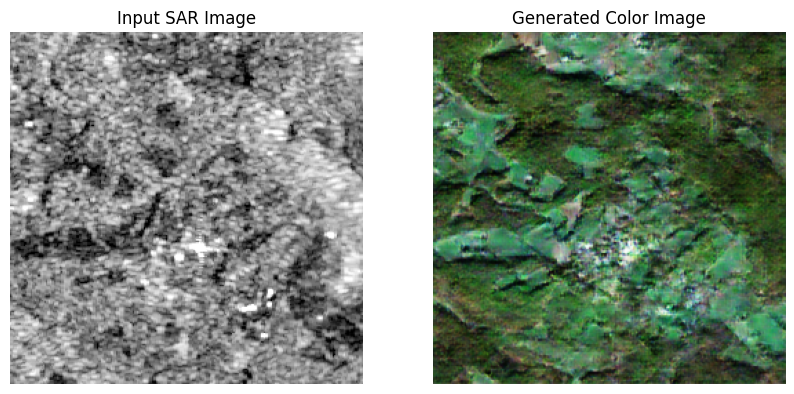

Saved: /content/drive/MyDrive/prototype/Testpred/generated_image_0_0.png


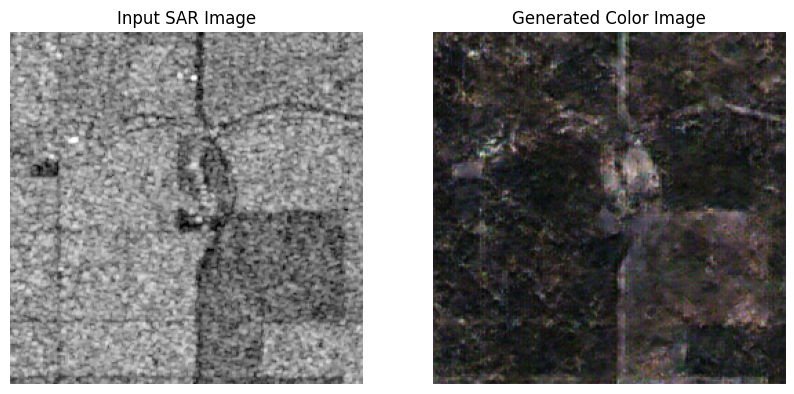

Saved: /content/drive/MyDrive/prototype/Testpred/generated_image_0_1.png


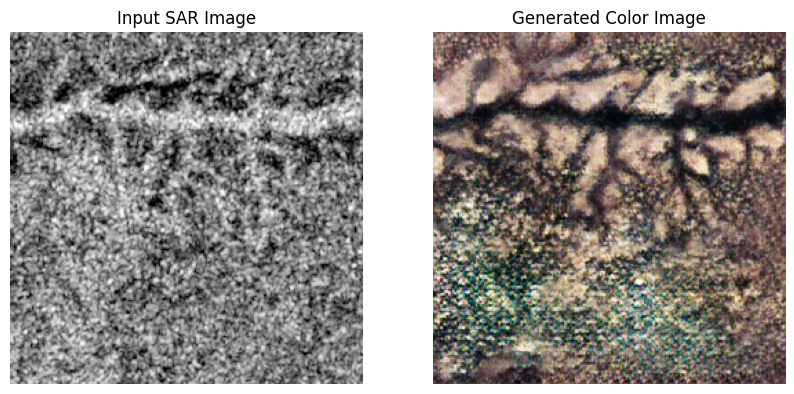

Saved: /content/drive/MyDrive/prototype/Testpred/generated_image_0_2.png


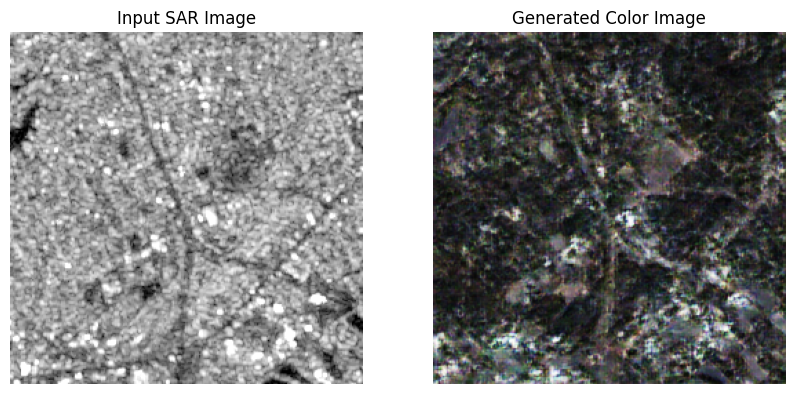

Saved: /content/drive/MyDrive/prototype/Testpred/generated_image_0_3.png


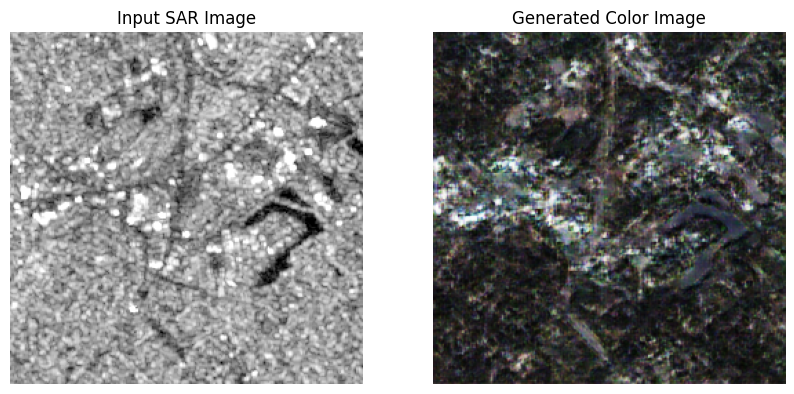

Saved: /content/drive/MyDrive/prototype/Testpred/generated_image_0_4.png


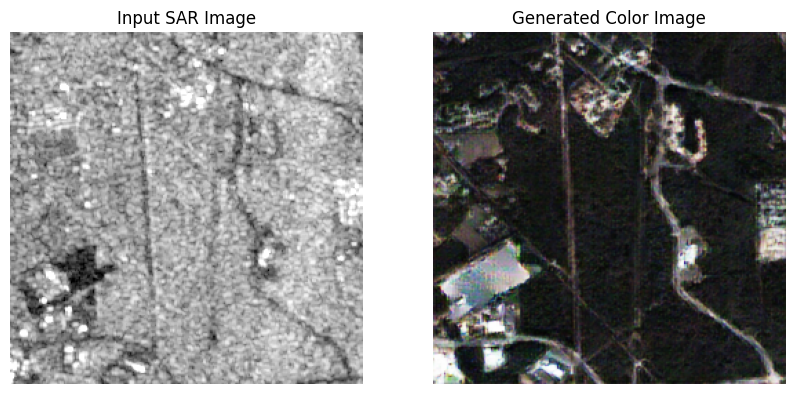

Saved: /content/drive/MyDrive/prototype/Testpred/generated_image_0_5.png


In [ ]:
import os
from PIL import Image

# Create Testpred directory if it doesn't exist
save_dir = "/content/drive/MyDrive/prototype/Testpred"
os.makedirs(save_dir, exist_ok=True)

# Load the generator model for testing
checkpoint_G = torch.load("/content/drive/MyDrive/prototype/Models/generator/generator.pth", map_location=torch.device('cpu'))
generator.load_state_dict(checkpoint_G['model_state_dict'])
optimizer_G.load_state_dict(checkpoint_G['optimizer_state_dict'])
generator.eval()  # Set the generator to evaluation mode


# Load test dataset for inference
test_dataset = ImageDataset(
    SAR_root="/content/drive/MyDrive/prototype/Test",
    color_root=None,  # Not needed for testing
    transforms_=transform
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False
)


# Function to test the generator, display images, and save them
def test_generator(generator, test_loader, num_images=5, save_dir=save_dir):
    generator.eval()  # Set the generator to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for faster inference
        for i, SAR_imgs in enumerate(test_loader):
            SAR_imgs = SAR_imgs.to(device)  # Move SAR images to the device
            generated_imgs = generator(SAR_imgs)
            generated_imgs = 0.5 * (generated_imgs + 1)  # Denormalize from [-1, 1] to [0, 1]
            SAR_imgs = SAR_imgs.cpu()
            generated_imgs = generated_imgs.cpu()

            # Display the first few images in the batch
            for j in range(min(num_images, SAR_imgs.size(0))):
                fig, axes = plt.subplots(1, 2, figsize=(10, 5))

                # Input SAR image
                axes[0].imshow(SAR_imgs[j].squeeze(0), cmap='gray')  # Display as grayscale
                axes[0].set_title('Input SAR Image')
                axes[0].axis('off')

                # Output colorized image
                axes[1].imshow(transforms.ToPILImage()(generated_imgs[j]))
                axes[1].set_title('Generated Color Image')
                axes[1].axis('off')

                plt.show()

                # Save the generated image
                generated_img_pil = transforms.ToPILImage()(generated_imgs[j])
                img_save_path = os.path.join(save_dir, f'generated_image_{i}_{j}.png')
                generated_img_pil.save(img_save_path)
                print(f"Saved: {img_save_path}")

# Run testing, visualization, and saving
test_generator(generator, test_dataloader, num_images=6)
